In [35]:
import matplotlib.pyplot as plt

from OOPAO.calibration.compute_KL_modal_basis import compute_M2C, compute_KL_basis

from trwfs.tools.PWFS_CMOS_NOISE_PROOF_may2022_tools import *
from tqdm import trange
from OOPAO.TR_Pyramid import Pyramid
from pypet import Environment, cartesian_product
from trwfs.parameter_files.parameterFile_CMOS_PWFS_aug2022_3 import initializeParameterFile
from OOPAO.tools.displayTools           import displayMap

param = initializeParameterFile()

# %% -----------------------     TELESCOPE   ----------------------------------

# create the Telescope object
tel = Telescope(resolution=param['resolution'], \
                diameter=param['diameter'], \
                samplingTime=param['samplingTime'], \
                centralObstruction=param['centralObstruction'])

# %% -----------------------     NGS   ----------------------------------
# create the Source object
ngs = Source(optBand=param['opticalBand'], \
             magnitude=1.0)

# combine the NGS to the telescope using '*' operator:
ngs * tel

tel.computePSF(zeroPaddingFactor=6)

# %% -----------------------     ATMOSPHERE   ----------------------------------

# create the Atmosphere object
atm = Atmosphere(telescope=tel, \
                 r0=param['r0'], \
                 L0=param['L0'], \
                 windSpeed=param['windSpeed'], \
                 fractionalR0=param['fractionnalR0'], \
                 windDirection=param['windDirection'], \
                 altitude=param['altitude'])

# initialize atmosphere
atm.initializeAtmosphere(tel)
#
# self.atm.update()
#
# self.tel + self.atm
# self.tel.computePSF(8)

# %% -----------------------     DEFORMABLE MIRROR   ----------------------------------
# mis-registrations object
misReg = MisRegistration(param)
# if no coordonates specified, create a cartesian dm

dm = DeformableMirror(telescope=tel, \
                      nSubap=param['nSubaperture'], \
                      mechCoupling=param['mechanicalCoupling'], \
                      misReg=misReg)


M2C_KL = compute_M2C(telescope            = tel, \
                     atmosphere         = atm, \
                     deformableMirror   = dm, \
                     param              = None, \
                     nameFolder         = None, \
                     nameFile           = None, \
                     remove_piston      = True, \
                     HHtName            = None, \
                     baseName           = None , \
                     mem_available      = 1e9, \
                     minimF             = False, \
                     nmo                = None, \
                     ortho_spm          = True, \
                     SZ                 = np.int64(2*tel.OPD.shape[0]), \
                     nZer               = 3, \
                     NDIVL              = 1, \
                     recompute_cov=True, \
                     save_output= False)


Reading/Writting calibration data from data_calibration/
Writting output data in data_cl/
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% TELESCOPE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
     Diameter             8                [m]        
    Resolution            80             [pixels]     
    Pixel Size           0.1               [m]        
     Surface             50.0              [m2]       
Central Obstruction        0          [% of diameter]  
Pixels in the pupil       5024            [pixels]     
      Source             None                         
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
No light propagated through the telescope
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% SOURCE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
      Source          Wavelength     Zenith [arcsec]    Azimuth [deg]      Altitude [m]       Magnitude      Flux [phot/m2/s] 
---------------------------------------------------------------------------------

In [36]:
# make sure tel and atm are separated to initialize the PWFS
tel-atm


wfs = Pyramid(nSubap                = param['nSubaperture'],\
              telescope             = tel,\
              modulation            = 3,\
              lightRatio            = param['lightThreshold'],\
              n_pix_separation      = 20,\
              n_pix_edge            = None,\
              psfCentering          = True,\
              postProcessing        = 'slopesMaps_incidence_flux',
              nTheta_user_defined = param['nTheta_user_defined'])

wfs_axicon = Pyramid(nSubap                = param['nSubaperture'],\
              telescope             = tel,\
              modulation            = 3,\
              lightRatio            = param['lightThreshold'],\
              n_pix_separation      = 20,\
              n_pix_edge            = None,\
              psfCentering          = False,\
              postProcessing        = 'fullFrame',userValidSignal=np.ones(wfs.cam.frame.shape).astype(bool),
              nTheta_user_defined = param['nTheta_user_defined'])


Telescope and Atmosphere separated!
Pyramid Mask initialization...
Selection of the valid pixels...
The valid pixel are selected on flux considerations
Acquisition of the reference slopes and units calibration...
WFS calibrated!
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% PYRAMID WFS %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
 Pupils Diameter          20             [pixels]     
Pupils Separation         20             [pixels]     
       FoV               1.63            [arcsec]     
  TT Modulation           3             [lamda/D]     
PSF Core Sampling         4             [pixel(s)]    
   Valid Pixels          704            [pixel(s)]    
Signal ComputationslopesMaps_incidence_flux
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Pyramid Mask initialization...
Selection of the valid pixels...
You are using a user-defined mask for the selection of the valid pixel
Acquisition of the reference slopes and units calibration...
WFS calibrated!
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% PYRAMI

Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


/tmp/ipykernel_26574/1527719251.py:19: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  axicone                             = (sp.morphology.distance_transform_edt(tmp))


<Figure size 432x288 with 0 Axes>

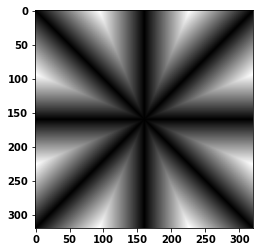

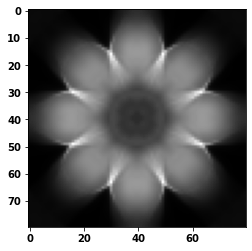

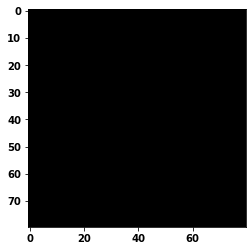

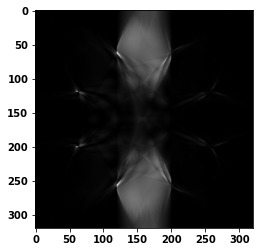

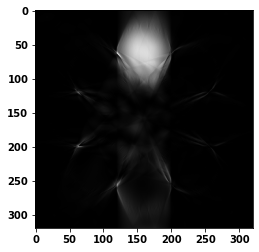

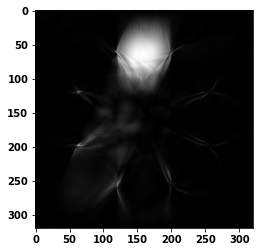

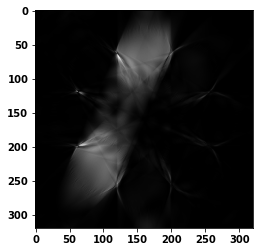

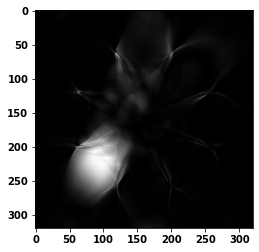

In [37]:
import scipy.ndimage as sp
plt.gray()
tmp                             = np.ones([wfs.nRes,wfs.nRes])
# tmp[wfs.nRes//2,wfs.nRes//2]                        = 0  #Axicone
for i in range(wfs.nRes):
    tmp[i,i] = 0
    tmp[-i,i] = 0
    tmp[wfs.nRes//2,i] = 0
    tmp[i,wfs.nRes//2] = 0

# lines = 12
# x = np.linspace(-wfs.nRes//2, wfs.nRes//2, wfs.nRes)
# y = np.linspace(-wfs.nRes//2, wfs.nRes//2, wfs.nRes)
# x,y = np.meshgrid(x,y)
# mask = np.zeros([wfs.nRes,wfs.nRes])
# for i in np.linspace(0, 360, 12):
#     mask += (np.abs(np.abs(y)/np.abs(wfs.nRes//2) - np.abs(np.sin(i))) < 0.01) & (np.abs(np.abs(x)/(wfs.nRes//2) - np.abs(np.cos(i))) < 0.01)
# tmp[mask>1] = 0
axicone                             = (sp.morphology.distance_transform_edt(tmp))


axicone /= axicone.max()

axicone -= 0.5

axicone*=wfs.m.max()
axicone/=2

# axicone = wfs.m

wfs_axicon.mask = np.exp(1j*axicone)
# here we set the modulation to a new value to re-define the reference signal
wfs_axicon.modulation = 3


ngs*tel*wfs_axicon

plt.figure(),plt.imshow(axicone)
plt.figure(),plt.imshow(wfs_axicon.cam.frame)
plt.figure(),plt.imshow(wfs_axicon.signal_2D)

tmp = np.abs(np.asarray(wfs_axicon.modulation_camera_em))**2

ref_map = wfs_axicon.maps
for i in range(5):
    plt.figure()
    plt.imshow(wfs_axicon.maps[i,:,:])

<Figure size 432x288 with 0 Axes>

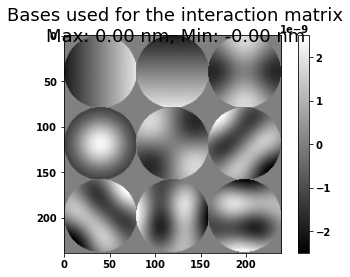

In [38]:
dm.coefs = M2C_KL[:, 0:9] * 1e-9
tel * dm * wfs
plt.gray()
displayMap(tel.OPD)


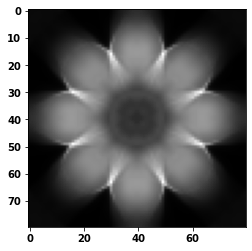

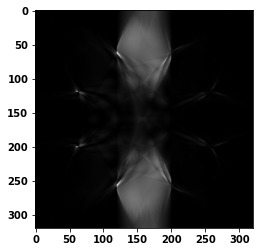

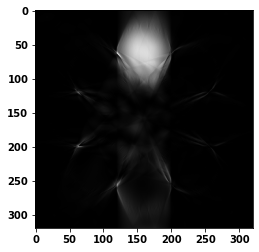

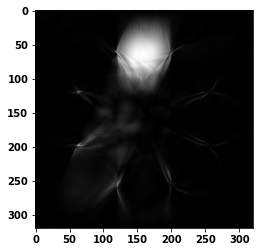

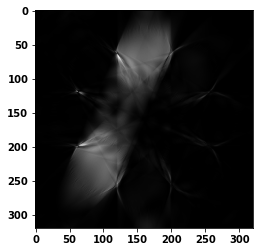

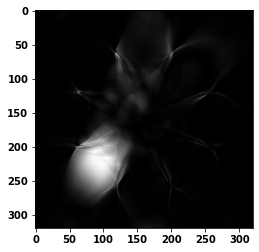

In [39]:
ngs*tel*dm*wfs_axicon


plt.figure(),plt.imshow(wfs_axicon.cam.frame)
# plt.figure(),plt.imshow(wfs_axicon.signal_2D)

tmp = np.abs(np.asarray(wfs_axicon.modulation_camera_em))**2

abe_maps = wfs_axicon.maps

for i in range(5):
    plt.figure()
    plt.imshow(wfs_axicon.maps[i,:,:])

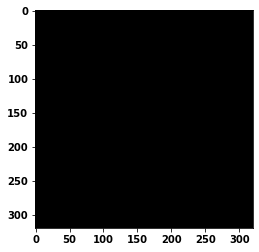

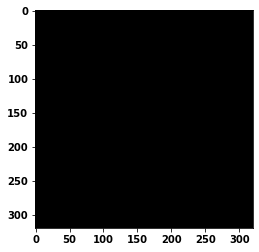

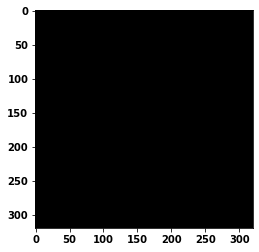

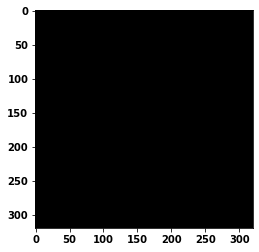

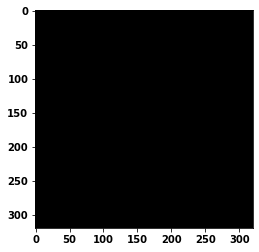

In [40]:
for i in range(5):
    plt.figure()
    abe_N = np.sum(abe_maps[i,:,:])
    ref_N = np.sum(ref_map[i,:,:])
    plt.imshow((abe_maps[i,:,:]/abe_N)-(ref_map[i,:,:]/ref_N) )

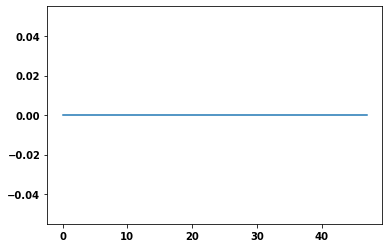

In [41]:
information = np.zeros((abe_maps.shape[0]))
for i in range(abe_maps.shape[0]):
    abe_N = np.sum(abe_maps[i,:,:])
    ref_N = np.sum(ref_map[i,:,:])
    information[i] = np.sqrt(np.mean(((abe_maps[i,:,:]/abe_N)-(ref_map[i,:,:]/ref_N))**2))

plt.figure()
plt.plot(information)

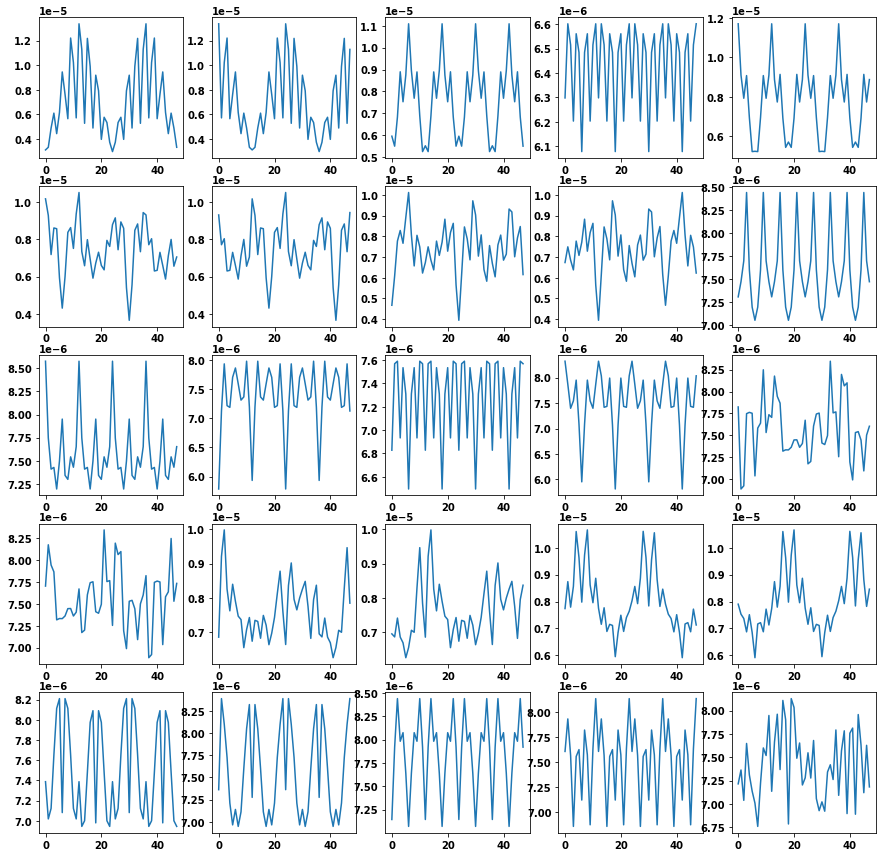

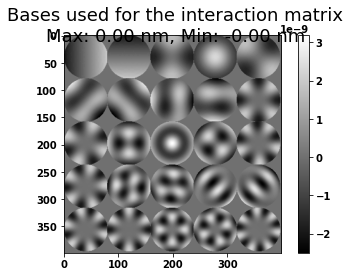

In [42]:



def calcInformation(base, stroke=1e-9):
    dm.coefs = 0
    tel * dm * wfs_axicon

    ref_maps= wfs_axicon.maps


    dm.coefs = M2C_KL[:, base] * stroke
    tel * dm * wfs_axicon

    abe_maps= wfs_axicon.maps

    for i in range(abe_maps.shape[0]):
        abe_N = np.sum(abe_maps[i,:,:])
        ref_N = np.sum(ref_maps[i,:,:])
        information[i] = np.sqrt(np.mean(((abe_maps[i,:,:]/abe_N)-(ref_maps[i,:,:]/ref_N))**2))

    return information

fig, ax = plt.subplots(5,5, figsize=(15,15))
for i in range(25):
    ax[i//5, i%5].plot(calcInformation(i, stroke=50*1e-9))

dm.coefs = M2C_KL[:, 0:25] * 1e-9
tel * dm * wfs
plt.gray()
displayMap(tel.OPD)

